/Users/takumiresearch/cryptocurrency/vaultanalyser/metrics/sharpe_reliability.py:147: RuntimeWarning: divide by zero encountered in log
  T = -2.0 * np.sum(w * np.log(p))


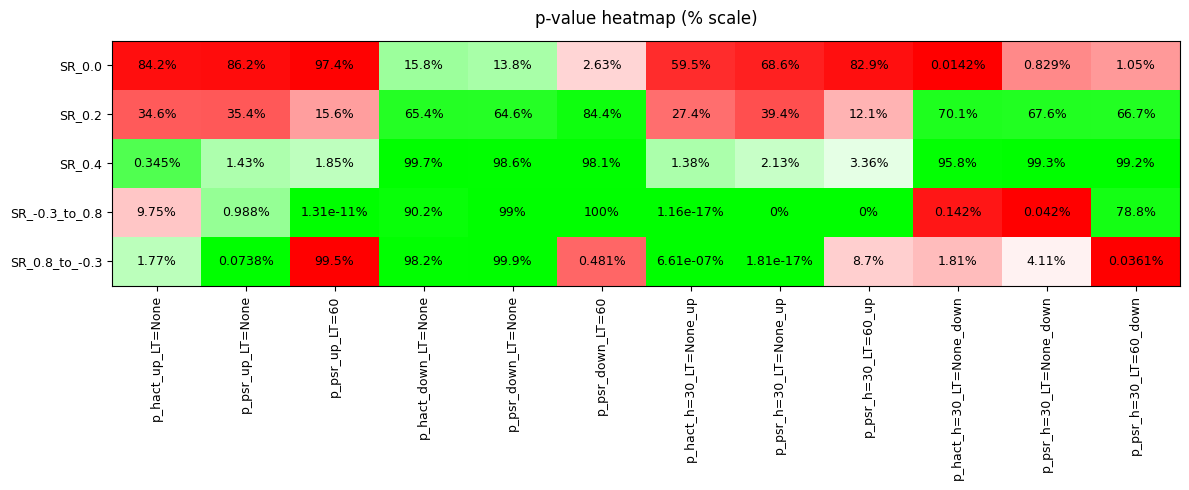

In [ ]:
import numpy as np
import pandas as pd
from sharpe_reliability import calculate_sharpe_reliability
import matplotlib.pyplot as plt


np.random.seed(0)


def make_series(sr, n=252, sigma=0.01):
    mu = sr * sigma
    returns = np.random.normal(mu, sigma, n)
    pnl = np.concatenate([[1.0], (1 + returns).cumprod()])
    return pnl


def make_two_period(sr1, sr2, n1=126, n2=126, sigma=0.01):
    ret1 = np.random.normal(sr1 * sigma, sigma, n1)
    ret2 = np.random.normal(sr2 * sigma, sigma, n2)
    returns = np.concatenate([ret1, ret2])
    pnl = np.concatenate([[1.0], (1 + returns).cumprod()])
    return pnl


# ── 1 区間シリーズ ───────────────────────
single_srs = [0.0, 0.2, 0.4]
data_dict = {f"SR_{sr}": make_series(sr) for sr in single_srs}

# ── 2 区間シリーズ ───────────────────────
two_period_srs = [(-0.2, 0.8), (0.8, -0.2)]
data_dict |= {
    f"SR_{sr1}_to_{sr2}": make_two_period(sr1, sr2)
    for sr1, sr2 in two_period_srs
}

# compute p-values
rows = []
for name, pnl in data_dict.items():
    pv = calculate_sharpe_reliability(pnl, h=30, LT=60, SR0=0.1)
    pv["dataset"] = name
    rows.append(pv)

df = pd.DataFrame(rows).set_index("dataset")





# -------------  CONFIG  -----------------
p_threshold = 0.05
cell_fontsize = 9          # show full numbers
percent_fmt = "{:.3g}%"    # one decimal place
# ----------------------------------------

# Expect a DataFrame named `p_values` from previous step
# Scale to percent
df_pct = df * 100.0

# Column masks
up_cols   = df_pct.columns.str.contains("_up")
down_cols = df_pct.columns.str.contains("_down")

# Build RGB array
def log_intensity(p: float, p_th: float) -> tuple[float, bool]:
    """
    返り値: (inten, is_sig_side)
        inten ∈ [0,1]   … 0: まっ白, 1: 濃色
        is_sig_side     … True なら p ≤ p_th (有意側)
    """
    if p <= p_th:                  # 有意側  → 緑 or 赤（列で決定）
        p_end = 1e-3
        inten = (np.log10(p_th) - np.log10(max(p, 1e-300))) / (np.log10(p_th) - np.log10(p_end))
        return min(inten, 1.0), True
    else:                          # 非有意側 → 赤 or 緑
        p_end = 1.0
        inten = (np.log10(min(p, 1.0)) - np.log10(p_th)) / (np.log10(p_end) - np.log10(p_th))
        return min(inten, 1.0), False


rgb = np.zeros((*df_pct.shape, 3))

for i in range(df_pct.shape[0]):
    for j in range(df_pct.shape[1]):
        p_val = df.iat[i, j]
        if np.isnan(p_val):
            rgb[i, j] = (0.85, 0.85, 0.85)
            continue

        inten, sig_side = log_intensity(p_val, p_threshold)

        if up_cols[j]:                     # *_up 列
            if sig_side:                   # 有意 → green
                rgb[i, j] = (1-inten, 1, 1-inten)
            else:                          # 非有意 → red
                rgb[i, j] = (1, 1-inten, 1-inten)

        elif down_cols[j]:                 # *_down 列（反転）
            if sig_side:                   # 有意 → red
                rgb[i, j] = (1, 1-inten, 1-inten)
            else:                          # 非有意 → green
                rgb[i, j] = (1-inten, 1, 1-inten)

        else:                              # その他列
            rgb[i, j] = (0.15 + 0.85*p_val,
                          0.18 + 0.72*p_val,
                          1.00)

# Plot
fig_w = df_pct.shape[1] * 1.0
fig_h = df_pct.shape[0]
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.imshow(rgb, interpolation='nearest', aspect='auto')
ax.set_xticks(range(df_pct.shape[1]))
ax.set_yticks(range(df_pct.shape[0]))
ax.set_xticklabels(df_pct.columns, rotation=90, ha='center', fontsize=9)
ax.set_yticklabels(df_pct.index, fontsize=9)

# annotate with percentage values
for i in range(df_pct.shape[0]):
    for j in range(df_pct.shape[1]):
        val = df_pct.iat[i, j]
        txt = "" if np.isnan(val) else percent_fmt.format(val)
        ax.text(j, i, txt, ha='center', va='center',
                fontsize=cell_fontsize, color='black')

ax.set_title("p-value heatmap (% scale)", pad=12)
plt.tight_layout()
plt.show()
